<a href="https://colab.research.google.com/github/ravindu374/Automated-Power-Saving-Unit/blob/main/Assignment2_EN3160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Assignment 2**

In [91]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Question 1

In [92]:
file_path = '/content/drive/MyDrive/openCV/the_berry_farms_sunflower_field.jpeg'
img = cv.imread(file_path,cv.IMREAD_REDUCED_COLOR_4)
assert img is not None
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)


In [104]:
# Select range of sigma
sigma_values = np.linspace(1,2, 9)
# Threhsold for blob detection
threshold = 0.38

# Store responses of each scale
blob_responses = []

for sigma in sigma_values:
    print(f"Processing scale with sigma = {sigma}")

    # Apply Gaussian blur
    gaussian_blur = cv.GaussianBlur(gray, (0, 0), sigma)
    # Compute Laplacian of Gaussian (LoG)
    laplacian = cv.Laplacian(gaussian_blur, cv.CV_64F)
    # Get absolute value
    blob_response = np.abs(laplacian)

    # Threshold the response and get contours
    mask = blob_response > threshold * blob_response.max()
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw contours as circles
    for contour in contours:
        if len(contour) >= 5:
            # Get the center and radius of the enclosing circle from contour
            (center_x, center_y), radius = cv.minEnclosingCircle(contour)
            # Convert to integers
            center = (int(center_x), int(center_y))
            radius = int(radius)
            blob_responses.append((center, radius, sigma))
#print(blob_responses)


Processing scale with sigma = 1.0
Processing scale with sigma = 1.125
Processing scale with sigma = 1.25
Processing scale with sigma = 1.375
Processing scale with sigma = 1.5
Processing scale with sigma = 1.625
Processing scale with sigma = 1.75
Processing scale with sigma = 1.875
Processing scale with sigma = 2.0


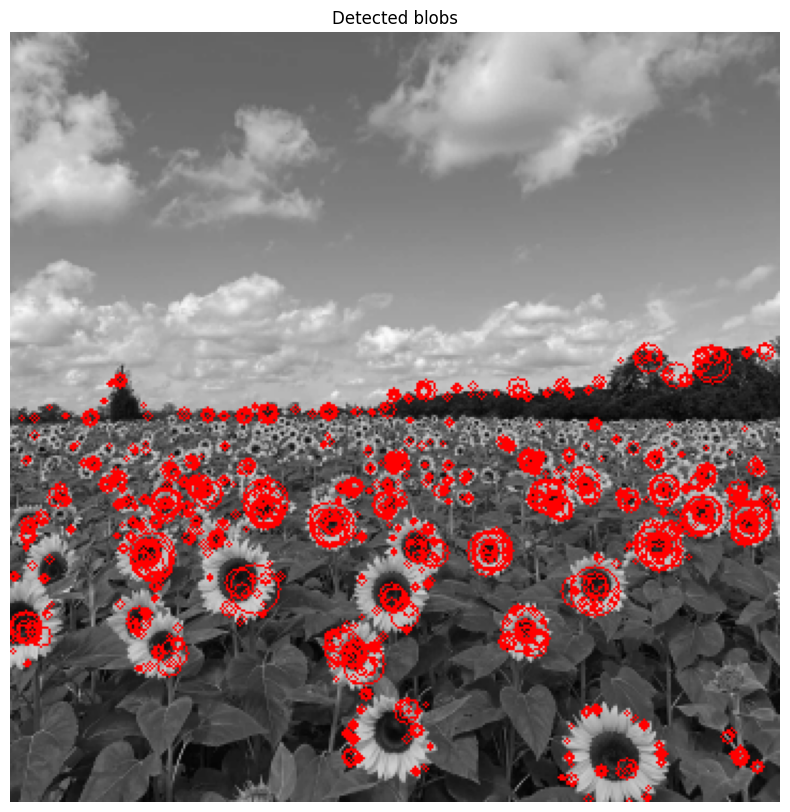

In [105]:
# Draw all detected circles with the specified line thickness
output = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)
for blob in blob_responses:
    center, radius, _ = blob
    cv.circle(output, center, radius, (0, 0, 255), 1)

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected blobs')
plt.show()

In [106]:
# Get largest circle
blobs_sorted = sorted(blob_responses, key=lambda x: x[1], reverse=True)
largest_blob = blobs_sorted[0]
center, radius, sigma = largest_blob

# Print largest circle details
print(f"Largest blob at : {center} with radius {radius} and sigma {sigma}")

Largest blob at : (273, 261) with radius 12 and sigma 2.0


0.71,0.99,1.27,1.56,1.84,2.12,2.40,2.69,2.97,3.25,3.54,3.82,4.10,4.38,4.67,4.95,5.23,5.52,5.80,6.08,6.36,6.65,6.93,7.21,7.50,

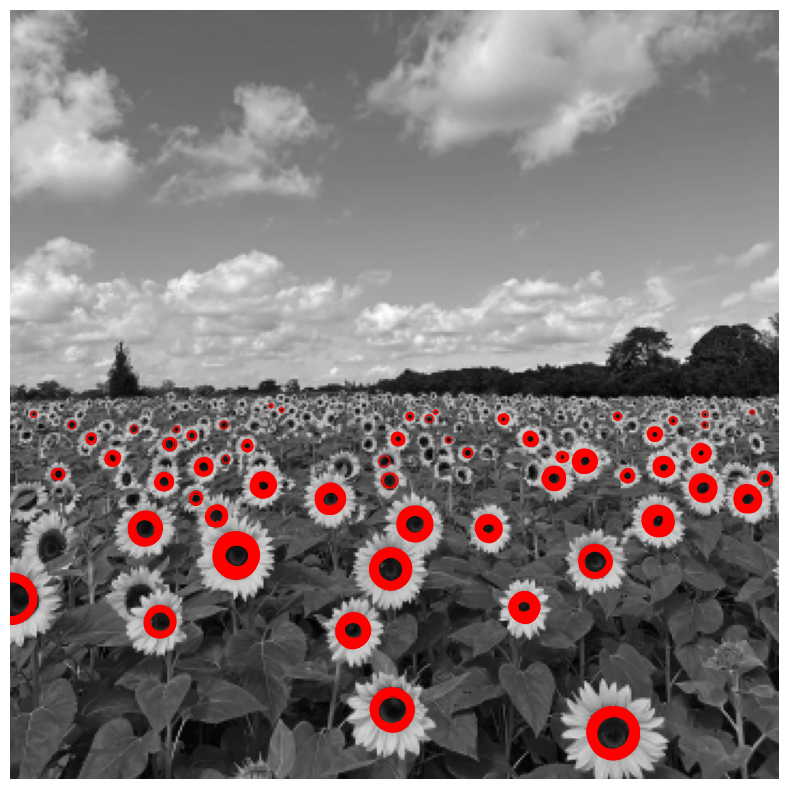

In [123]:
import matplotlib.colors as mcolors

# Load the image and convert it to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) / 255

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10), frameon=False)
plt.imshow(gray, cmap='gray')
plt.axis('off')

# Get the current axes object
ax = plt.gca()

patches = []
labels = []

# Detect blobs at different sigma values
for r in np.arange(1,11,0.4):
    sigma = r / 1.414
    print(f"{sigma:.2f}", end=",")
    hw = round(3 * sigma)  # Half width of the kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    # Calculate Laplacian of Gaussian (LoG) filter
    LOG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)

    # Scale the filter and apply it to the image
    LOG = sigma**2 * LOG
    img1_log = np.square(cv.filter2D(gray, -1, LOG))

    # Detect maxima manually
    coordinates = []
    (H, W) = img1_log.shape
    k = 1  # Neighborhood size
    threshold = 0.1  # Threshold for maxima detection
    for i in range(k, H - k):
        for j in range(k, W - k):
            slice_img = img1_log[i - k:i + k + 1, j - k:j + k + 1]
            if np.max(slice_img) >= threshold:
                # Get coordinates of the maximum point
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i + x - k, j + y - k))
    coordinates = set(coordinates)

    # Plot circles around detected blobs
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color='r', linewidth=1, fill=False)
        ax.add_patch(c)
    patches.append(c)
    ax.plot()

ax.set_xlim([0, img.shape[1]])
ax.set_ylim([img.shape[0], 0])

# Add legend and title
plt.axis('off')
plt.show()

##Question 2

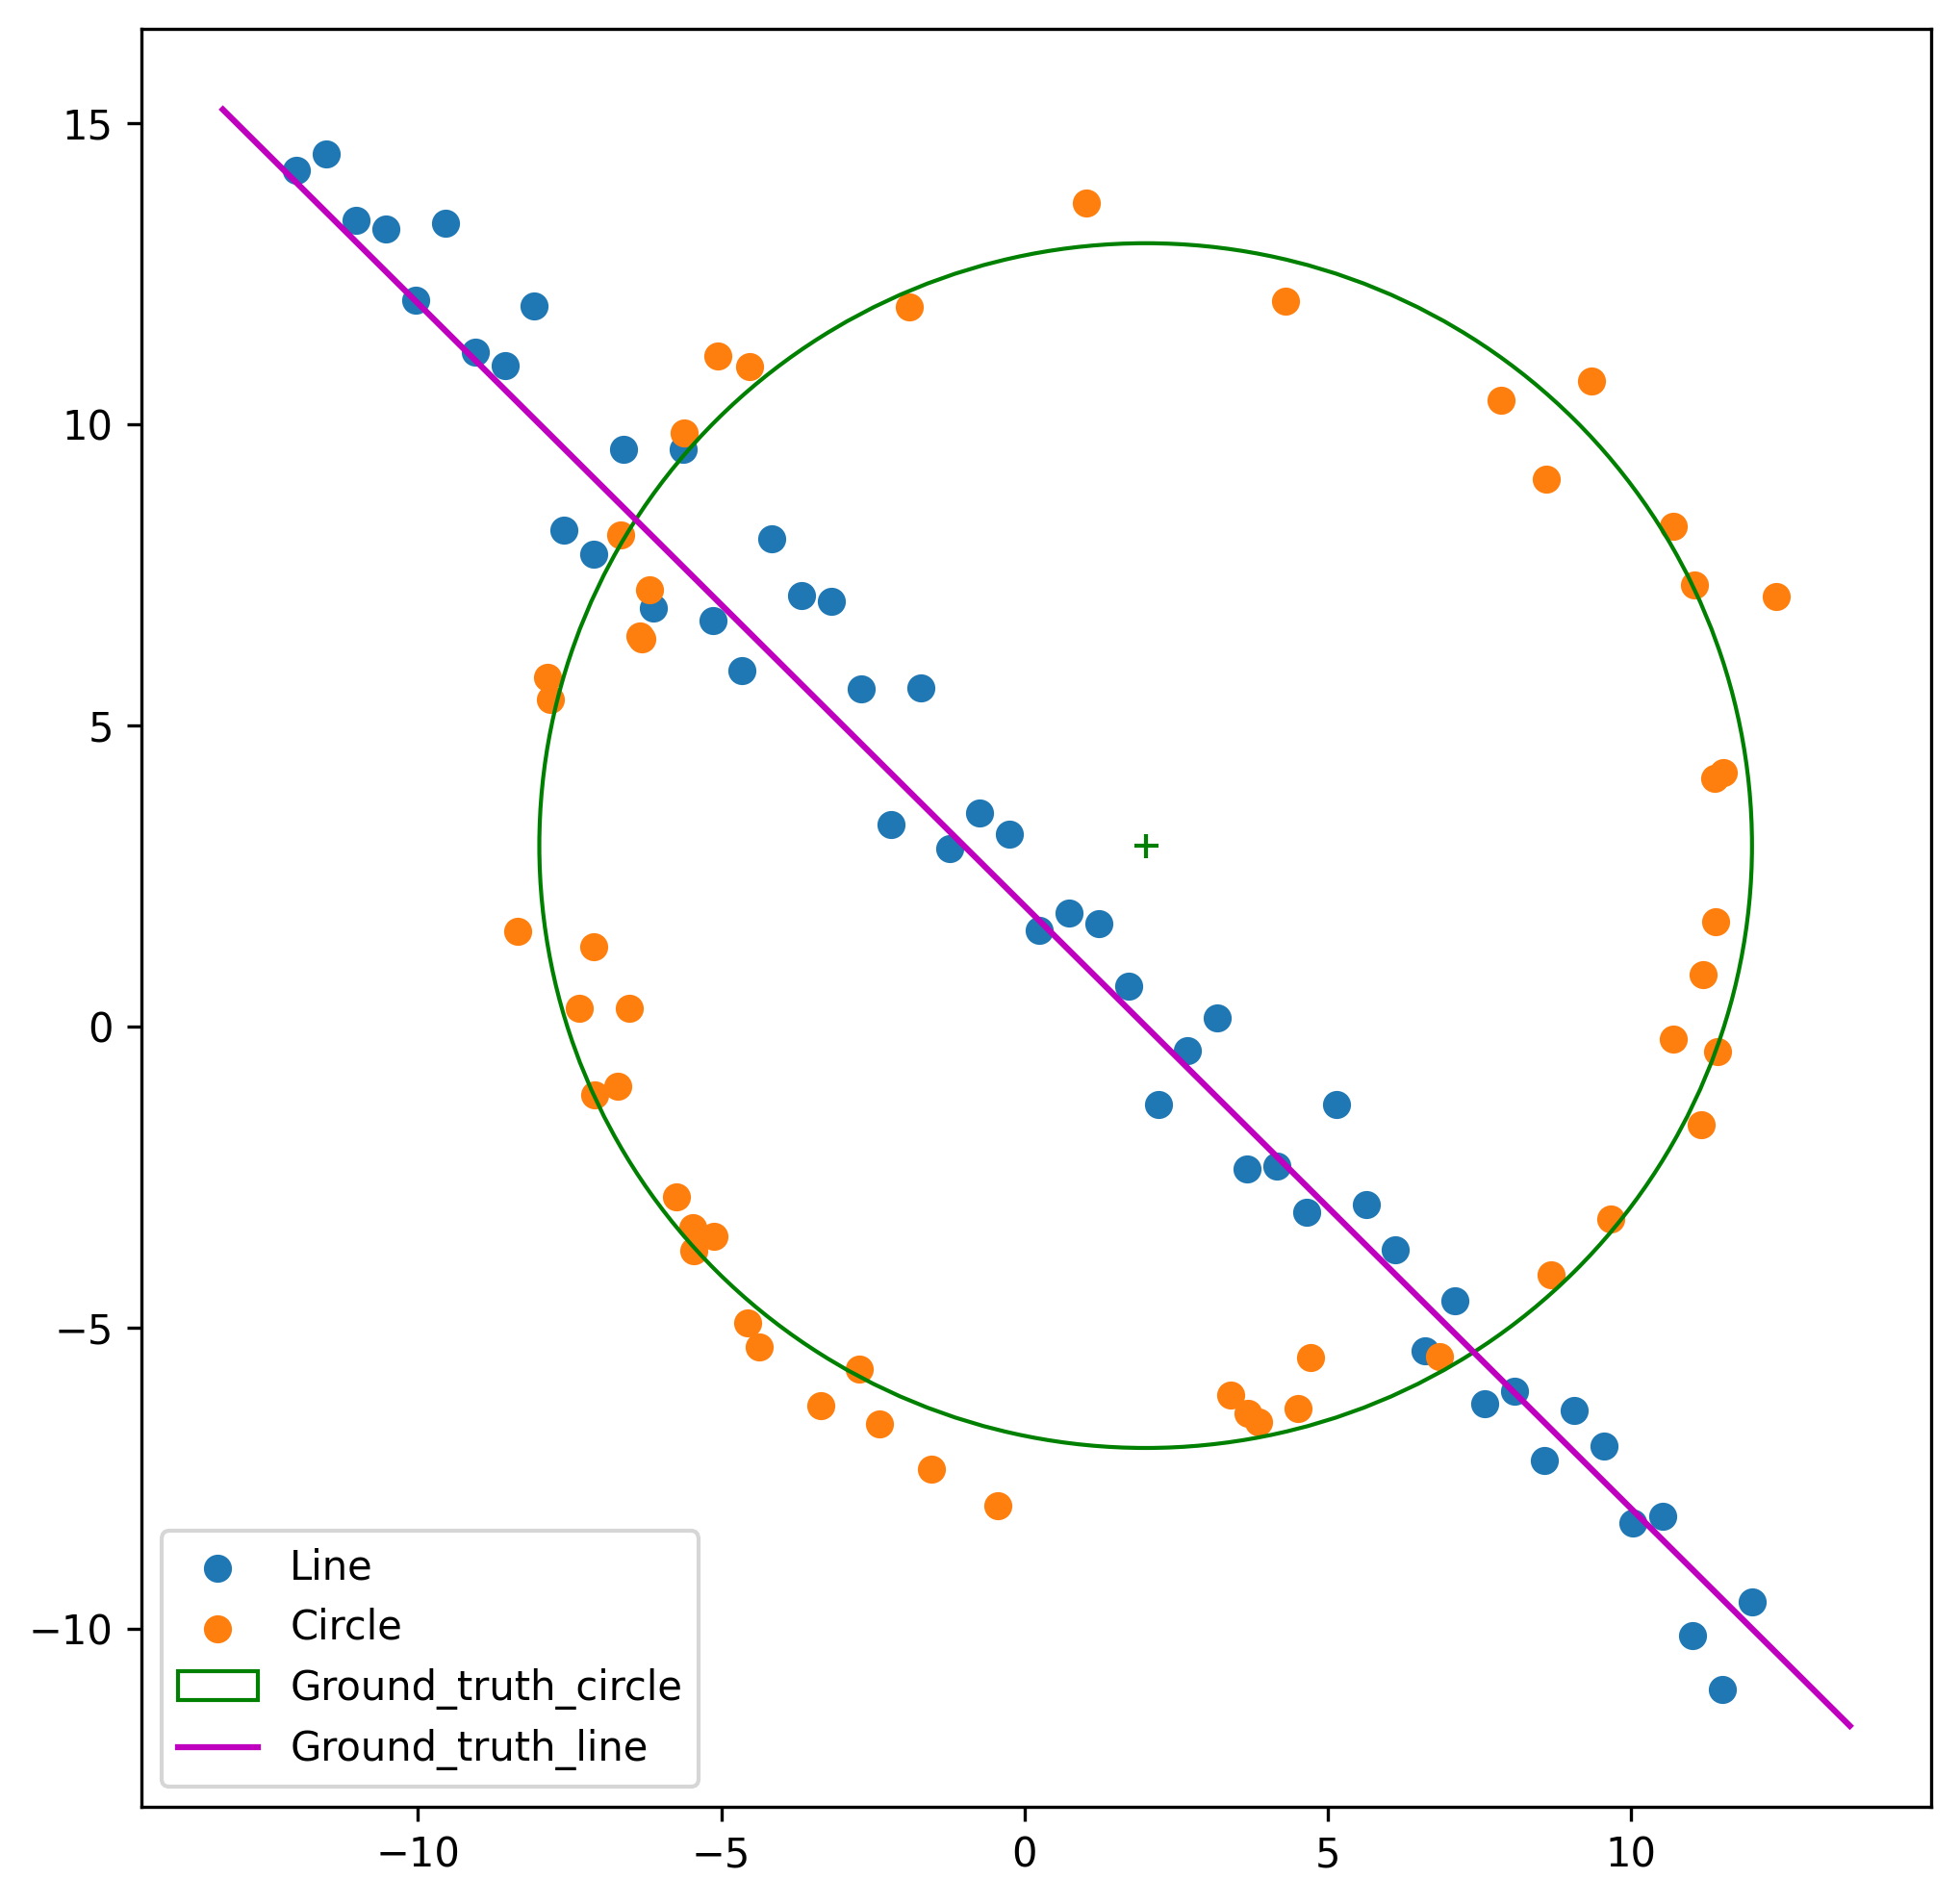

In [2]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
N = 100
half_n = N//2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=300)
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')
plt.legend()

###RANSAC for line fitting

###Part (a)

Estimated line parameters (a, b, d): [np.float64(-0.7184192033652615), np.float64(-0.6956104141227495), np.float64(1.4753449080312475)]
Number of inliers: 36


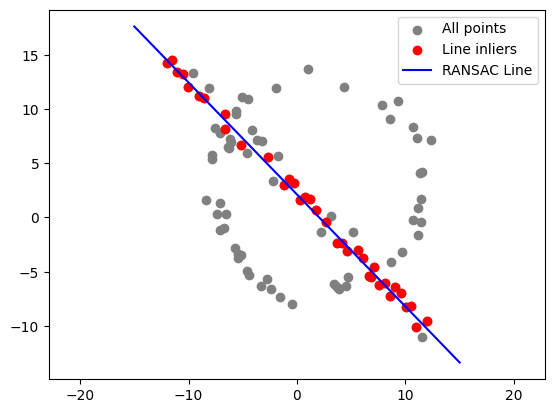

In [3]:
def fit_line(p1,p2):
  # ax + by + d = 0  with ||[a,b]||=1
  a = p2[1]-p1[1]
  b = p1[0]-p2[0]
  d = -(a*p1[0]+b*p1[1])
  # Ensure the constraint ||[a,b]|| = 1
  norm = np.sqrt(a**2+b**2)
  return a/norm , b/norm , d/norm

def line_error(params,point):
  a,b,d = params
  x,y = point
  return abs(a*x+b*y+d)

def ransac_line(X, n_iter=1000,threshold=0.6,min_inliers=36):
  best_inliers = []
  best_params = []
  n_points = X.shape[0]

  for _ in range(n_iter):
    # Randomly pick 2 points
    idx = np.random.choice(n_points, 2, replace=False)
    p1, p2 = X[idx]
    a, b, d = fit_line(p1, p2)

    # Count inliers
    inliers = []
    for i, pt in enumerate(X):
            if line_error((a, b, d), pt) < threshold:
                inliers.append(i)

    # Update best model
    if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
      best_inliers = inliers
      best_params = [a, b, d]
  return best_params, best_inliers
# Run RANSAC
params, inliers = ransac_line(X)

print("Estimated line parameters (a, b, d):", params)
print("Number of inliers:", len(inliers))

# Plot result
plt.scatter(X[:,0], X[:,1], c='gray', label="All points")
plt.scatter(X[inliers,0], X[inliers,1], c='red', label="Line inliers")

# Plot fitted line
a,b,d = params
x_vals = np.linspace(-15, 15, 100)
y_vals = (-a*x_vals - d) / b
plt.plot(x_vals, y_vals, 'b-', label="RANSAC Line")

plt.legend()
plt.axis("equal")
plt.show()

###Part(b)

RANSAC line (a,b,d): [np.float64(-0.7184192033652615), np.float64(-0.6956104141227495), np.float64(1.4753449080312475)]
Line inliers: 36
RANSAC circle (cx, cy, r): (np.float64(1.9277604387522498), np.float64(2.7509014741218762), np.float64(9.590001363179214))
Circle inliers: 52


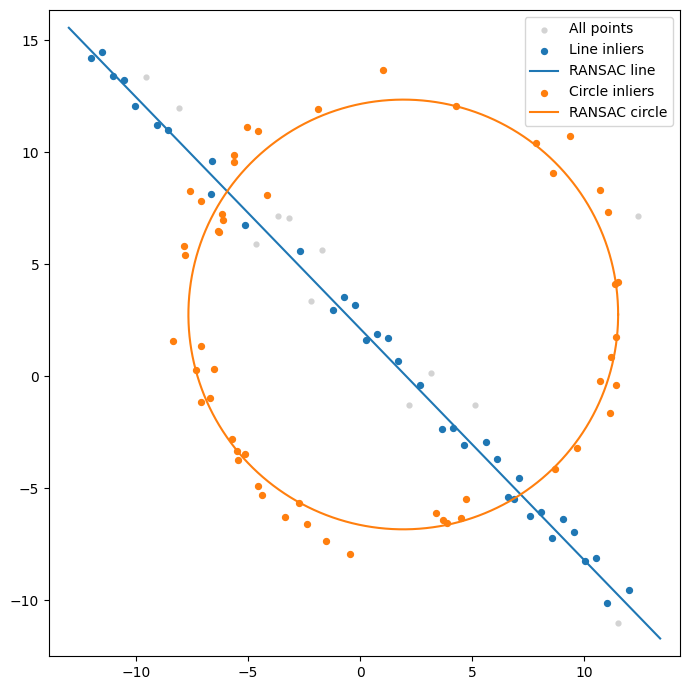

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#Generate the same synthetic dataset
np.random.seed(0)
N = 100
half_n = N // 2

r_gt = 10
cx_gt, cy_gt = 2, 3
s_circ = r_gt / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s_circ * np.random.randn(half_n)
x, y = cx_gt + (r_gt + n)*np.cos(t), cy_gt + (r_gt + n)*np.sin(t)
X_circ = np.vstack((x, y)).T

s_line = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s_line*np.random.randn(half_n)
X_line = np.vstack((x, y)).T

X = np.vstack((X_circ, X_line))  # all points

#RANSAC Line --
def fit_line(p1, p2):
    # ax + by + d = 0  with ||[a,b]||=1
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    d = -(a*p1[0] + b*p1[1])
    nrm = np.hypot(a, b)
    return a/nrm, b/nrm, d/nrm

def line_dist(params, pt):
    a, b, d = params
    x, y = pt
    return abs(a*x + b*y + d)  # normal distance; ||[a,b]||=1

def ransac_line(X, n_iter=800, thresh=0.60, min_inliers=36):
    best_params, best_inliers = [], []
    n = len(X)
    for _ in range(n_iter):
        i, j = np.random.choice(n, 2, replace=False)
        a, b, d = fit_line(X[i], X[j])
        inliers = [k for k, p in enumerate(X) if line_dist((a,b,d), p) < thresh]
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers, best_params = inliers, [a, b, d]
    return best_params,best_inliers# np.array(best_inliers, dtype=int)

line_params, line_inliers = ransac_line(X)
# Remove line consensus to get remnant for circle fitting
mask = np.ones(len(X), dtype=bool)
mask[line_inliers] = False
X_rem = X[mask]

#RANSAC Circle
def circle_from_3pts(p1, p2, p3):
    """Return (cx, cy, r) from 3 non-collinear points; raise ValueError if collinear."""
    (x1,y1), (x2,y2), (x3,y3) = p1, p2, p3
    A = np.array([
        [2*(x2-x1), 2*(y2-y1)],
        [2*(x3-x1), 2*(y3-y1)]
    ], dtype=float)
    b = np.array([
        x2**2 - x1**2 + y2**2 - y1**2,
        x3**2 - x1**2 + y3**2 - y1**2
    ], dtype=float)
    if abs(np.linalg.det(A)) < 1e-9:
        raise ValueError("Collinear")
    cx, cy = np.linalg.solve(A, b)
    r = np.hypot(x1 - cx, y1 - cy)
    return cx, cy, r

def radial_error(c, r, pt):
    return abs(np.hypot(pt[0]-c[0], pt[1]-c[1]) - r)

def ransac_circle(X, n_iter=1500, thresh=0.6, min_inliers=25):
    best_model, best_inliers =[], []
    n = len(X)
    if n < 3:
        return None, np.array([], dtype=int)
    idx_all = np.arange(n)
    for _ in range(n_iter):
        i,j,k = np.random.choice(n, 3, replace=False)
        try:
            cx, cy, r = circle_from_3pts(X[i], X[j], X[k])
        except ValueError:
            continue
        c = np.array([cx, cy])
        errs = np.array([radial_error(c, r, p) for p in X])
        inliers = idx_all[errs < thresh]
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_model = (cx, cy, r)
    return best_model, best_inliers

circle_model, circle_inliers_local = ransac_circle(X_rem, n_iter=800, thresh=1.5, min_inliers=45)

# Map circle inlier indices back to original X indices
rem_indices = np.where(mask)[0]
circle_inliers = rem_indices[circle_inliers_local]

print("RANSAC line (a,b,d):", line_params)
print("Line inliers:", len(line_inliers))
print("RANSAC circle (cx, cy, r):", circle_model)
print("Circle inliers:", len(circle_inliers))

#quick plot to verify
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], s=12, c='lightgray', label='All points')

# plot line inliers and fitted line
plt.scatter(X[line_inliers,0], X[line_inliers,1], s=18, label='Line inliers')
a,b,d = line_params
xx = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
yy = (-a*xx - d)/b
plt.plot(xx, yy, label='RANSAC line')

# plot circle inliers and fitted circle
cx, cy, r = circle_model
plt.scatter(X[circle_inliers,0], X[circle_inliers,1], s=18, label='Circle inliers')
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(cx + r*np.cos(theta), cy + r*np.sin(theta), label='RANSAC circle')

plt.axis('equal'); plt.legend(); plt.tight_layout(); plt.show()


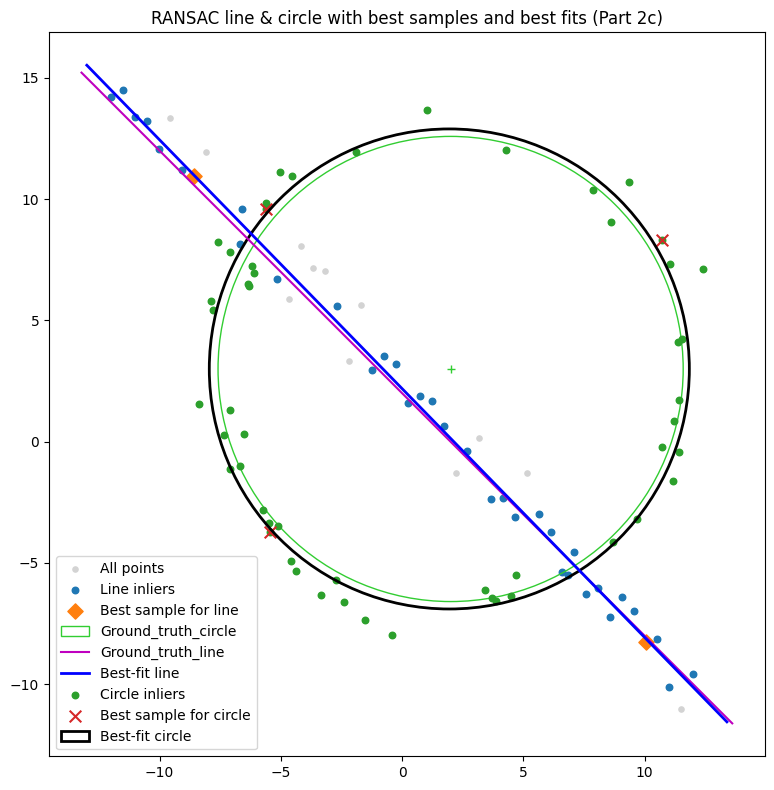

Line (best sample)   a,b,d = (np.float64(-0.7184192033652615), np.float64(-0.6956104141227495), np.float64(1.4753449080312475))
Circle (best sample) cx,cy,r = (np.float64(2.0732016632652632), np.float64(3.031148268720094), np.float64(10.11033486610821))


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Circle

#Synthetic dataset
np.random.seed(0)
N = 100
half_n = N // 2

# Circle cluster
r_gt = 10
cx_gt, cy_gt = 2, 3
s_circ = r_gt / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s_circ * np.random.randn(half_n)
x = cx_gt + (r_gt + n)*np.cos(t)
y = cy_gt + (r_gt + n)*np.sin(t)
X_circ = np.vstack((x, y)).T

# Line cluster
s_line = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s_line*np.random.randn(half_n)
X_line = np.vstack((x, y)).T

X = np.vstack((X_circ, X_line))

#Helpers
def fit_line_from_two_points(p1, p2):
    """Return normalized (a,b,d) for line ax+by+d=0 from two points."""
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    d = -(a*p1[0] + b*p1[1])
    nrm = np.hypot(a, b)
    return a/nrm, b/nrm, d/nrm

def line_errors(params, P):
    a, b, d = params
    return np.abs(P @ np.array([a, b]) + d)  # normal distance; ||[a,b]||=1

def refine_line_tls(P_in):
    """Total least squares line fit on inliers -> normalized (a,b,d)."""
    mu = P_in.mean(axis=0)
    C = P_in - mu
    # SVD: last right-singular vector is normal
    _, _, Vt = np.linalg.svd(C, full_matrices=False)
    n = Vt[-1]                 # normal (a,b)
    n = n / np.linalg.norm(n)  # ensure unit
    a, b = n
    d = -(a*mu[0] + b*mu[1])
    return a, b, d

def circle_from_3pts(p1, p2, p3):
    """Return (cx, cy, r) from 3 non-collinear points. Raises ValueError if collinear."""
    (x1,y1), (x2,y2), (x3,y3) = p1, p2, p3
    A = np.array([[2*(x2-x1), 2*(y2-y1)],
                  [2*(x3-x1), 2*(y3-y1)]], dtype=float)
    b = np.array([x2**2 - x1**2 + y2**2 - y1**2,
                  x3**2 - x1**2 + y3**2 - y1**2], dtype=float)
    if abs(np.linalg.det(A)) < 1e-9:
        raise ValueError("Collinear sample for circle")
    cx, cy = np.linalg.solve(A, b)
    r = np.hypot(x1 - cx, y1 - cy)
    return cx, cy, r

def circle_radial_errors(c, r, P):
    return np.abs(np.hypot(P[:,0]-c[0], P[:,1]-c[1]) - r)

def refine_circle_ls(P_in, init):
    """Nonlinear LS refine (cx,cy,r) on inliers using SciPy minimize."""
    def obj(theta):
        cx, cy, r = theta
        return np.sum((np.hypot(P_in[:,0]-cx, P_in[:,1]-cy) - r)**2)
    res = minimize(obj, x0=np.array(init, dtype=float), method="L-BFGS-B")
    cx, cy, r = res.x
    return cx, cy, r

#RANSAC for line (store best sample & refine)
def ransac_line(P, n_iter=1000, thresh=0.6, min_inliers=35):
    best = {"inliers": np.array([], int), "params": None, "sample_idx": None}
    n = len(P)
    for _ in range(n_iter):
        i, j = np.random.choice(n, 2, replace=False)
        a, b, d = fit_line_from_two_points(P[i], P[j])
        errs = line_errors((a,b,d), P)
        inliers = np.where(errs < thresh)[0]
        if len(inliers) > len(best["inliers"]) and len(inliers) >= min_inliers:
            best["inliers"] = inliers
            best["params"]  = (a, b, d)
            best["sample_idx"] = (i, j)
    return best

line_res = ransac_line(X, n_iter=1000, thresh=0.6, min_inliers=35)
line_params_samp = line_res["params"]        # from the best 2-point sample
line_inliers = line_res["inliers"]
i_samp_line, j_samp_line = line_res["sample_idx"]
line_best_sample_pts = X[[i_samp_line, j_samp_line]]

# Refine line on its inliers via TLS
a_tls, b_tls, d_tls = refine_line_tls(X[line_inliers])

#RANSAC for circle on the remnant (store best sample & refine)
mask = np.ones(len(X), dtype=bool)
mask[line_inliers] = False
X_rem = X[mask]
rem_to_full = np.where(mask)[0]  # map indices back to X

def ransac_circle(P, n_iter=1000, thresh=1.5, min_inliers=45):
    best = {"inliers": np.array([], int), "model": None, "sample_idx": None}
    n = len(P)
    if n < 3:
        return best
    for _ in range(n_iter):
        i, j, k = np.random.choice(n, 3, replace=False)
        try:
            cx, cy, r = circle_from_3pts(P[i], P[j], P[k])
        except ValueError:
            continue
        errs = circle_radial_errors((cx,cy), r, P)
        inliers = np.where(errs < thresh)[0]
        if len(inliers) > len(best["inliers"]) and len(inliers) >= min_inliers:
            best["inliers"] = inliers
            best["model"]   = (cx, cy, r)
            best["sample_idx"] = (i, j, k)
    return best

circ_res = ransac_circle(X_rem, n_iter=1000, thresh=1.5, min_inliers=45)
(cx_s, cy_s, r_s) = circ_res["model"]               # from best 3-pt sample
circ_inliers_local = circ_res["inliers"]
i_s, j_s, k_s = circ_res["sample_idx"]
circ_best_sample_pts = X_rem[[i_s, j_s, k_s]]
circ_inliers_full = rem_to_full[circ_inliers_local]  # map to full X indices

# Refine circle on its inliers via nonlinear LS
cx_b, cy_b, r_b = refine_circle_ls(X[circ_inliers_full], (cx_s, cy_s, r_s))

#Plot everything in one figure
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(X[:,0], X[:,1], s=14, c='lightgray', label='All points')

# Line inliers and best-sample points
ax.scatter(X[line_inliers,0], X[line_inliers,1], s=22, label='Line inliers')
ax.scatter(line_best_sample_pts[:,0], line_best_sample_pts[:,1], s=60, marker='D', label='Best sample for line')

# Plot the original points
#ax.scatter(X_line[:,0], X_line[:,1], label='Line')
#ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='limegreen', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='limegreen')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')


# Plot best-fit (TLS) line
if abs(b_tls) > 1e-9:
    yy_tls = (-a_tls*xx - d_tls)/b_tls
    ax.plot(xx, yy_tls, 'b-', lw=2, label='Best-fit line')
else:
    x0 = -d_tls/a_tls
    ax.plot([x0,x0], [X[:,1].min()-1, X[:,1].max()+1], 'b-', lw=2, label='Best-fit line')

# Circle inliers and best-sample 3 points
ax.scatter(X[circ_inliers_full,0], X[circ_inliers_full,1], s=22, label='Circle inliers')
ax.scatter(circ_best_sample_pts[:,0], circ_best_sample_pts[:,1], s=70, marker='x', label='Best sample for circle')

# Plot best-fit circle on inliers
circ_best = Circle((cx_b, cy_b), r_b, fill=False, edgecolor='k', linewidth=2, label='Best-fit circle')
ax.add_patch(circ_best)

ax.set_aspect('equal', adjustable='box')
ax.legend(loc='best')
ax.set_title('RANSAC line & circle with best samples and best fits (Part 2c)')
plt.tight_layout()
plt.show()

# Print summaries
print("Line (best sample)   a,b,d =", (a_s, b_s, d_s))
#print("Line (TLS best-fit)  a,b,d =", (a_tls, b_tls, d_tls), " | inliers:", len(line_inliers))
print("Circle (best sample) cx,cy,r =", (cx_s, cy_s, r_s))
#print("Circle (LS best-fit) cx,cy,r =", (cx_b, cy_b, r_b), " | inliers:", len(circ_inliers_full))


In [36]:
print("Number of inliers in the line:", len(line_inliers))
print("Parameters of the estimated line:")
print(f"a: {a_s}")
print(f"b: {b_s}")
print(f"d: {d_s}")

Number of inliers in the line: 36
Parameters of the estimated line:
a: -0.7184192033652615
b: -0.6956104141227495
d: 1.4753449080312475


In [38]:
print("Number of inliers in the circle:", len(circle_inliers))
print("Parameters of the estimated circle:")
print(f"x_center: {cx_s}")
print(f"y_center: {cy_s}")
print(f"radius: {r_s}")

Number of inliers in the circle: 52
Parameters of the estimated circle:
x_center: 2.0732016632652632
y_center: 3.031148268720094
radius: 10.11033486610821


###Question 4